In [11]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import warnings
warnings.filterwarnings("ignore")
from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import corner

In [16]:
test = Table.read('../../Surveys/xmatch_galah_gaiadr3_tmass_skymapper.fits')

In [2]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../spectrum_post_processing/galah_dr4_allspec_not_validated_220620.fits')
#galah_dr4_raw['tmass_id'] = np.array(galah_dr4_raw['tmass_id'][:,0],dtype='str')

In [3]:
gaia_dr3 = Table.read('../../Surveys/Gaia_DR3/gaiadr3.astrophysical_parameters_xmatch_galah.fits')

In [4]:
# Join them with the tmass_id keyword
joined = join(galah_dr4_raw, gaia_dr3, keys='sobject_id')
gaia_dr3 = []; galah_dr4_raw = []

In [5]:
joined['fe_h_gspphot'] = joined['mh_gspphot']
joined['fe_h_gspspec'] = joined['mh_gspspec']

# Comparison of HRD

In [6]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,cmap='seismic_r',minimum_bin_entries = 5,colorbar_orientation='vertical',**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    X/Y/Z_label : label names
    bins = 30, but you can also give it bins = (np.linspace(x_min,x_max,30),np.linspace(y_min,y_max,30))
    bin_function : median/average/sum
    ax : if you plot it as part of an f,ax = plt.subplots()
    minimum_bin_entries : how many entries do we expect, before we even consider throwing some fancy function at them
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                elif bin_function=='std':
                    color_matrix[x_bin,y_bin]=np.std(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = cmap,aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax, orientation=colorbar_orientation)
    c.set_label(Z_label)

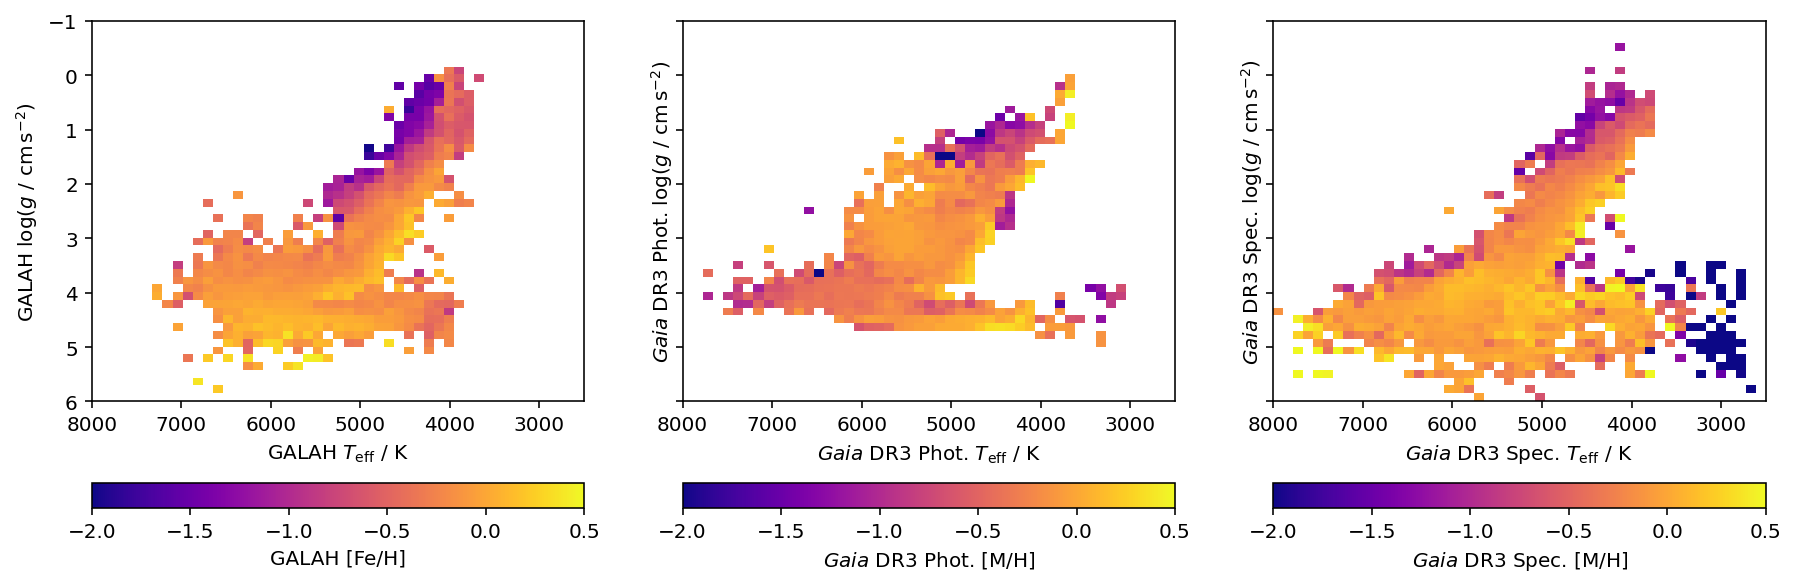

In [7]:
def plot_hrd_colored_by_median_feh():

    f, gs = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

    teff_limits = (2500,8000)
    logg_limits = (-1,6)

    use = (
        (joined['flag_sp'] == 0) &
        np.isfinite(joined['mh_gspphot']) &
        np.isfinite(joined['mh_gspspec'])
    )

    kwargs = dict(
        bins = (np.linspace(teff_limits[0],teff_limits[1],50),np.linspace(logg_limits[0],logg_limits[1],50)),
        cmap='plasma',
        minimum_bin_entries=1,
        colorbar_orientation='horizontal',
        vmin=-2.0,vmax=0.5)

    # GALAH
    ax = gs[0]
    ax.set_xlim(teff_limits[1],teff_limits[0])
    ax.set_ylim(logg_limits[1],logg_limits[0])

    hist2d_bin_colored(
        X = joined['teff'][use],
        Y = joined['logg'][use],
        Z = joined['fe_h'][use],
        X_label = r'GALAH $T_\mathrm{eff}~/~\mathrm{K}$',
        Y_label = r'GALAH $\log (g~/~\mathrm{cm\,s^{-2}})$',
        Z_label = r'GALAH [Fe/H]',
        ax = ax,**kwargs
    )

    # Gaia DR3 Photometry
    ax = gs[1]
    hist2d_bin_colored(
        X = joined['teff_gspphot'][use],
        Y = joined['logg_gspphot'][use],
        Z = joined['mh_gspphot'][use],
        X_label = r'$Gaia$ DR3 Phot. $T_\mathrm{eff}~/~\mathrm{K}$',
        Y_label = r'$Gaia$ DR3 Phot. $\log (g~/~\mathrm{cm\,s^{-2}})$',
        Z_label = r'$Gaia$ DR3 Phot. [M/H]',
        ax = ax,**kwargs
    )

    # Gaia DR3 Spectroscopy
    ax = gs[2]
    hist2d_bin_colored(
        X = joined['teff_gspspec'][use],
        Y = joined['logg_gspspec'][use],
        Z = joined['mh_gspspec'][use],
        X_label = r'$Gaia$ DR3 Spec. $T_\mathrm{eff}~/~\mathrm{K}$',
        Y_label = r'$Gaia$ DR3 Spec. $\log (g~/~\mathrm{cm\,s^{-2}})$',
        Z_label = r'$Gaia$ DR3 Spec. [M/H]',
        ax = ax,**kwargs
    )
plot_hrd_colored_by_median_feh()

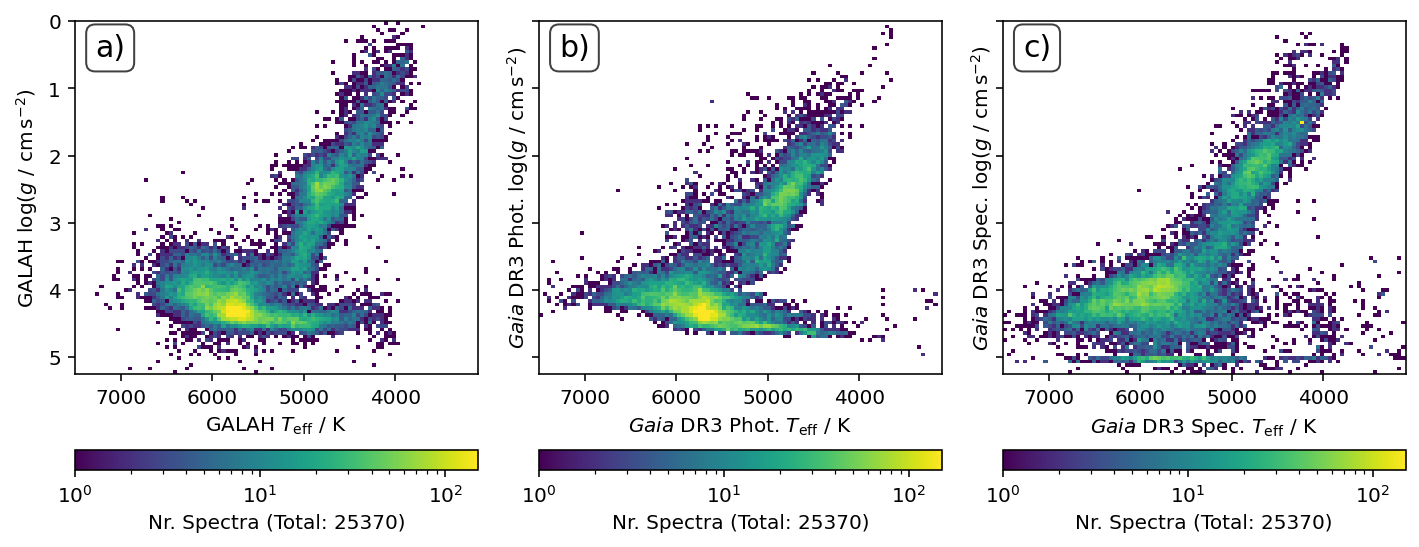

In [8]:
def plot_hrd_colored_by_density():

    f, gs = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)

    teff_limits = (3100,7500)
    logg_limits = (0,5.25)

    use = (
        (joined['flag_sp'] == 0) &
        np.isfinite(joined['mh_gspphot']) &
        np.isfinite(joined['mh_gspspec'])
    )

    kwargs = dict(
        bins = (np.linspace(teff_limits[0],teff_limits[1],100),np.linspace(logg_limits[0],logg_limits[1],100)),
        cmap='viridis',
        cmin=1,
        norm=LogNorm(vmin=1,vmax=150),
    )

    # GALAH
    ax = gs[0]
    ax.text(0.05,0.9,'a)',transform=ax.transAxes,fontsize=15,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'GALAH $T_\mathrm{eff}~/~\mathrm{K}$')
    ax.set_ylabel(r'GALAH $\log (g~/~\mathrm{cm\,s^{-2}})$')
    
    h = ax.hist2d(
        joined['teff'][use],
        joined['logg'][use],
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['teff_gspspec'][use]))+')')

    # Gaia DR3 Photometry
    ax = gs[1]
    ax.text(0.05,0.9,'b)',transform=ax.transAxes,fontsize=15,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$Gaia$ DR3 Phot. $T_\mathrm{eff}~/~\mathrm{K}$')
    ax.set_ylabel(r'$Gaia$ DR3 Phot. $\log (g~/~\mathrm{cm\,s^{-2}})$')

    h = ax.hist2d(
        joined['teff_gspphot'][use],
        joined['logg_gspphot'][use],
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['teff_gspspec'][use]))+')')

    # Gaia DR3 Spectroscopy
    ax = gs[2]
    ax.text(0.05,0.9,'c)',transform=ax.transAxes,fontsize=15,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$Gaia$ DR3 Spec. $T_\mathrm{eff}~/~\mathrm{K}$')
    ax.set_ylabel(r'$Gaia$ DR3 Spec. $\log (g~/~\mathrm{cm\,s^{-2}})$')
        
    h = ax.hist2d(
        joined['teff_gspspec'][use],
        joined['logg_gspspec'][use],
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['teff_gspspec'][use]))+')')

    
    ax.set_xlim(teff_limits[1],teff_limits[0])
    ax.set_ylim(logg_limits[1],logg_limits[0])
    
    plt.tight_layout()
    plt.savefig('figures/galah_dr4_validation_gaiadr3_hrd_density.png',dpi=200,bbox_inches='tight')
plot_hrd_colored_by_density()

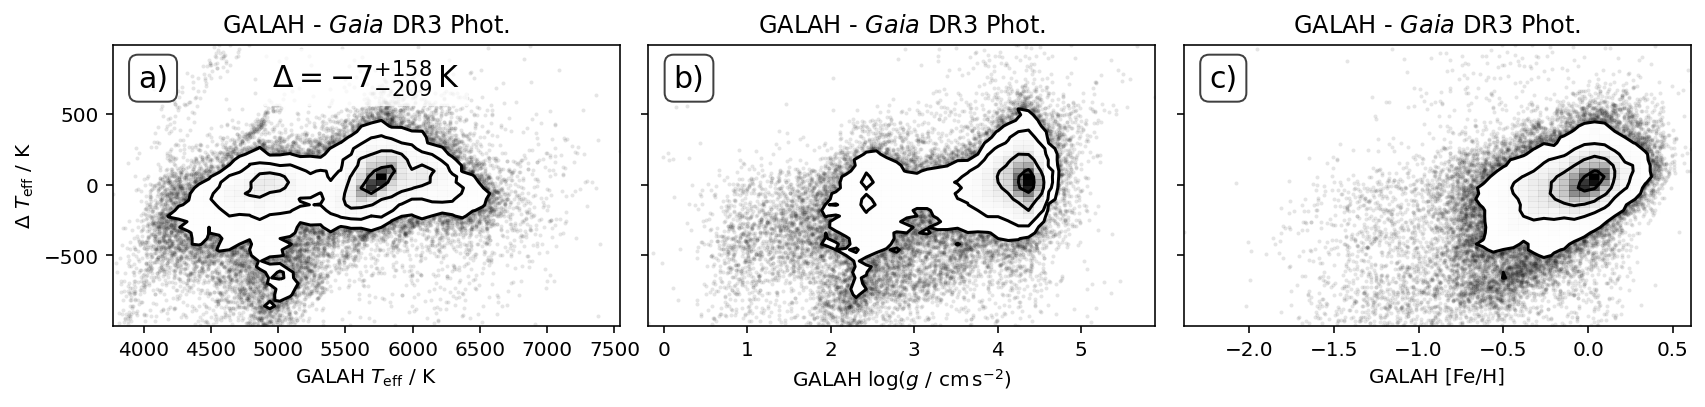

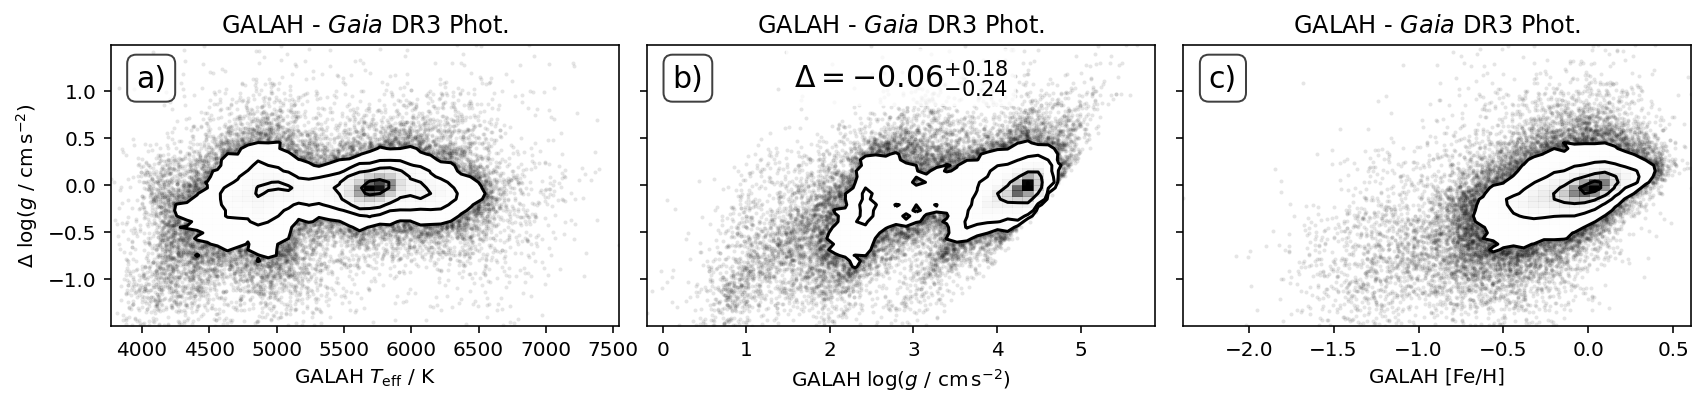

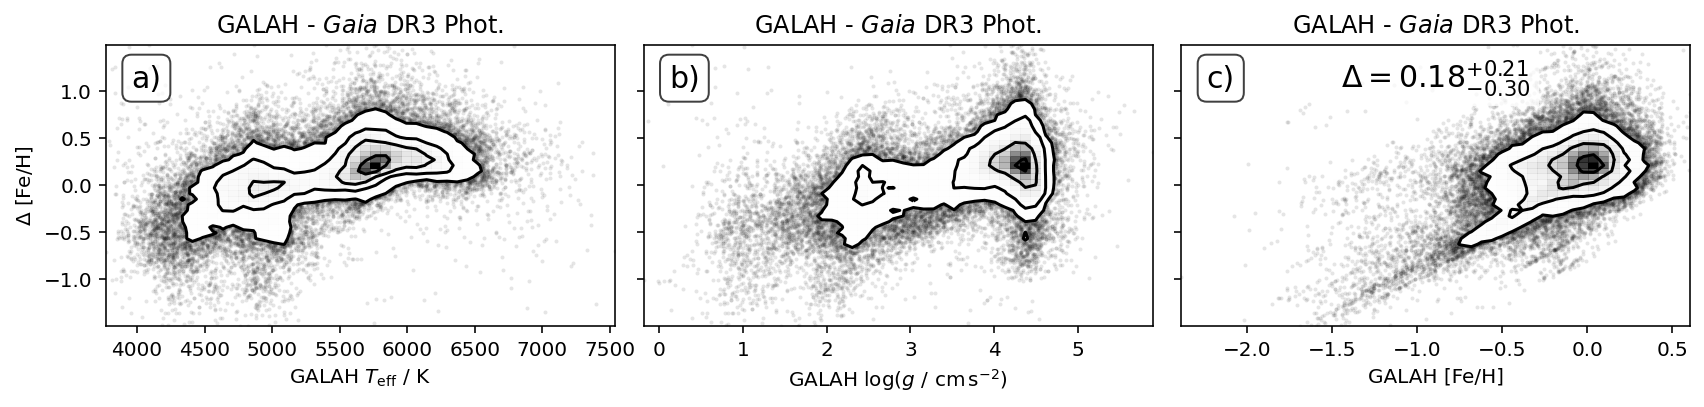

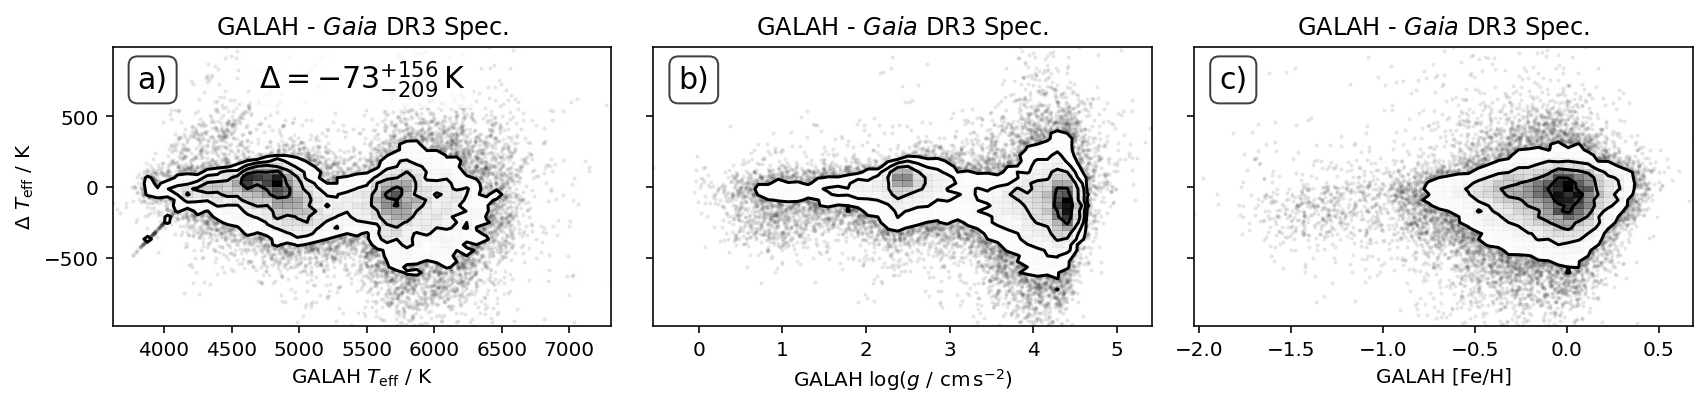

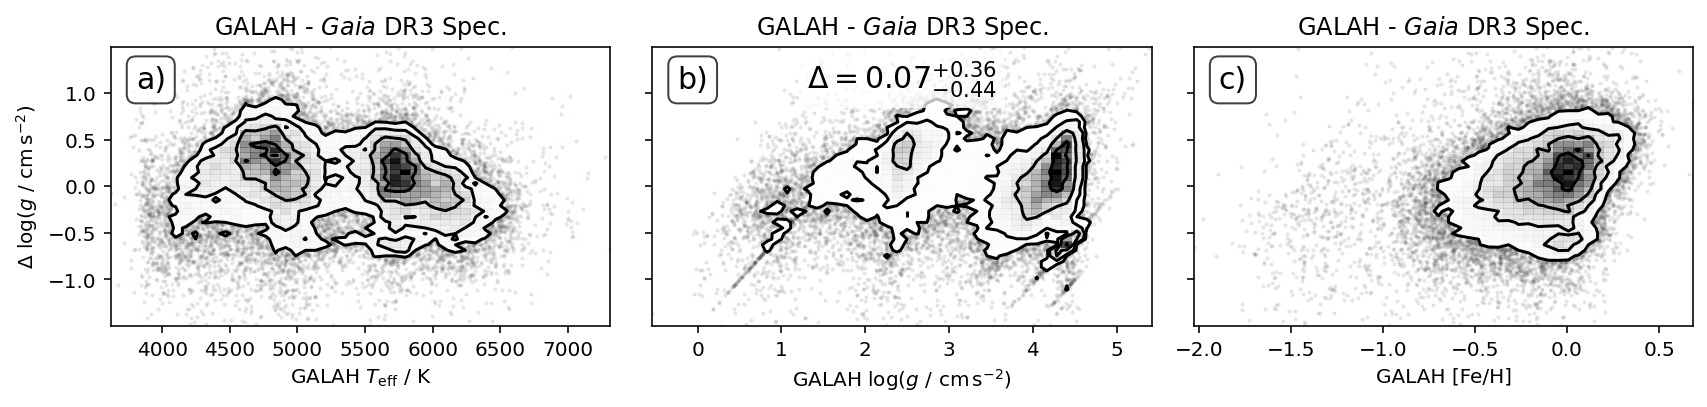

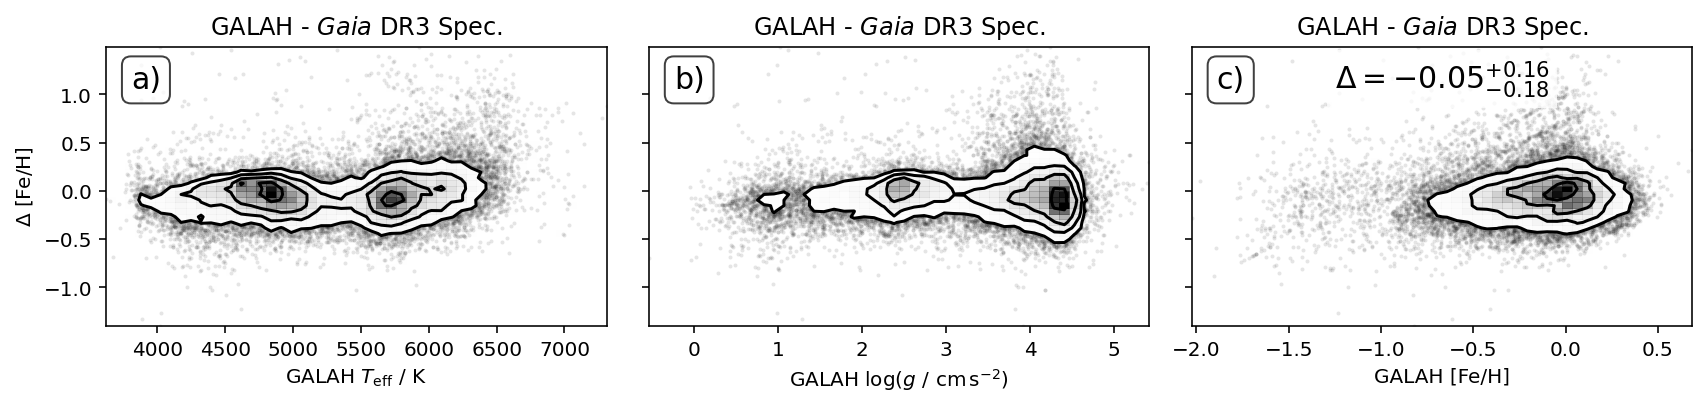

In [9]:
def calculate_difference_per_label(label, gaia_ref = 'Phot'):
    
    label_dict = dict()
    label_dict['teff'] = r'$T_\mathrm{eff}~/~\mathrm{K}$'
    label_dict['logg'] = r'$\log (g~/~\mathrm{cm\,s^{-2}})$'
    label_dict['fe_h'] = r'[Fe/H]'
    
    use = (
        (joined['flag_sp'] == 0) &
        np.isfinite(joined['mh_gsp'+gaia_ref.lower()]) &
        (np.abs(joined['teff']-joined['teff_gsp'+gaia_ref.lower()]) < 1000) &
        (np.abs(joined['logg']-joined['logg_gsp'+gaia_ref.lower()]) < 1.5) &
        (np.abs(joined['fe_h']-joined['fe_h_gsp'+gaia_ref.lower()]) < 1.5)
    )
    
    p16,p50,p84 = np.percentile(joined[label][use]-joined[label+'_gsp'+gaia_ref.lower()][use],q=[16,50,84])
    
    f, gs = plt.subplots(1,3,figsize=(12,3),sharey=True)
    
    if label=='teff':
        gs[0].text(0.5,0.85,
            r'$\Delta = {'+"{:.0f}".format(p50)+'}_{-'+"{:.0f}".format(p50-p16)+'}^{+'+"{:.0f}".format(p84-p50)+'}\,\mathrm{K}$',
            transform=gs[0].transAxes,fontsize=15,ha='center',bbox=dict(lw=0, facecolor='w', alpha=0.75)
        )
    elif label=='logg':
        gs[1].text(0.5,0.85,
            r'$\Delta = {'+"{:.2f}".format(p50)+'}_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',
            transform=gs[1].transAxes,fontsize=15,ha='center',bbox=dict(lw=0, facecolor='w', alpha=0.75)
        )
    elif label=='fe_h':
        gs[2].text(0.5,0.85,
            r'$\Delta = {'+"{:.2f}".format(p50)+'}_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',
            transform=gs[2].transAxes,fontsize=15,ha='center',bbox=dict(lw=0, facecolor='w', alpha=0.75)
        )
    
    ax = gs[0]
    ax.text(0.05,0.85,'a)',transform=ax.transAxes,fontsize=15,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'GALAH '+label_dict['teff'])
    ax.set_ylabel(r'$\Delta$ '+label_dict[label])
    ax.set_title(r'GALAH - $Gaia$ DR3 '+gaia_ref+'.')
                  
    corner.hist2d(
        joined['teff'][use],
        joined[label][use]-joined[label+'_gsp'+gaia_ref.lower()][use],
        ax=ax,bins=50
    )
        
    ax = gs[1]
    ax.text(0.05,0.85,'b)',transform=ax.transAxes,fontsize=15,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'GALAH '+label_dict['logg'])
    #ax.set_ylabel(r'$\Delta$ '+label_dict[label])
    ax.set_title(r'GALAH - $Gaia$ DR3 '+gaia_ref+'.')
                  
    corner.hist2d(
        joined['logg'][use],
        joined[label][use]-joined[label+'_gsp'+gaia_ref.lower()][use],
        ax=ax,bins=50
    )
    
    ax = gs[2]
    ax.text(0.05,0.85,'c)',transform=ax.transAxes,fontsize=15,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'GALAH '+label_dict['fe_h'])
    #ax.set_ylabel(r'$\Delta$ '+label_dict[label])
    ax.set_title(r'GALAH - $Gaia$ DR3 '+gaia_ref+'.')
                  
    corner.hist2d(
        joined['fe_h'][use],
        joined[label][use]-joined[label+'_gsp'+gaia_ref.lower()][use],
        ax=ax,bins=50
    )
    
    plt.tight_layout()
    
    plt.savefig('figures/galah_dr4_validation_gaiadr3_delta_'+label+'_'+gaia_ref.lower()+'.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

calculate_difference_per_label('teff', gaia_ref='Phot')
calculate_difference_per_label('logg', gaia_ref='Phot')
calculate_difference_per_label('fe_h', gaia_ref='Phot')
calculate_difference_per_label('teff', gaia_ref='Spec')
calculate_difference_per_label('logg', gaia_ref='Spec')
calculate_difference_per_label('fe_h', gaia_ref='Spec')

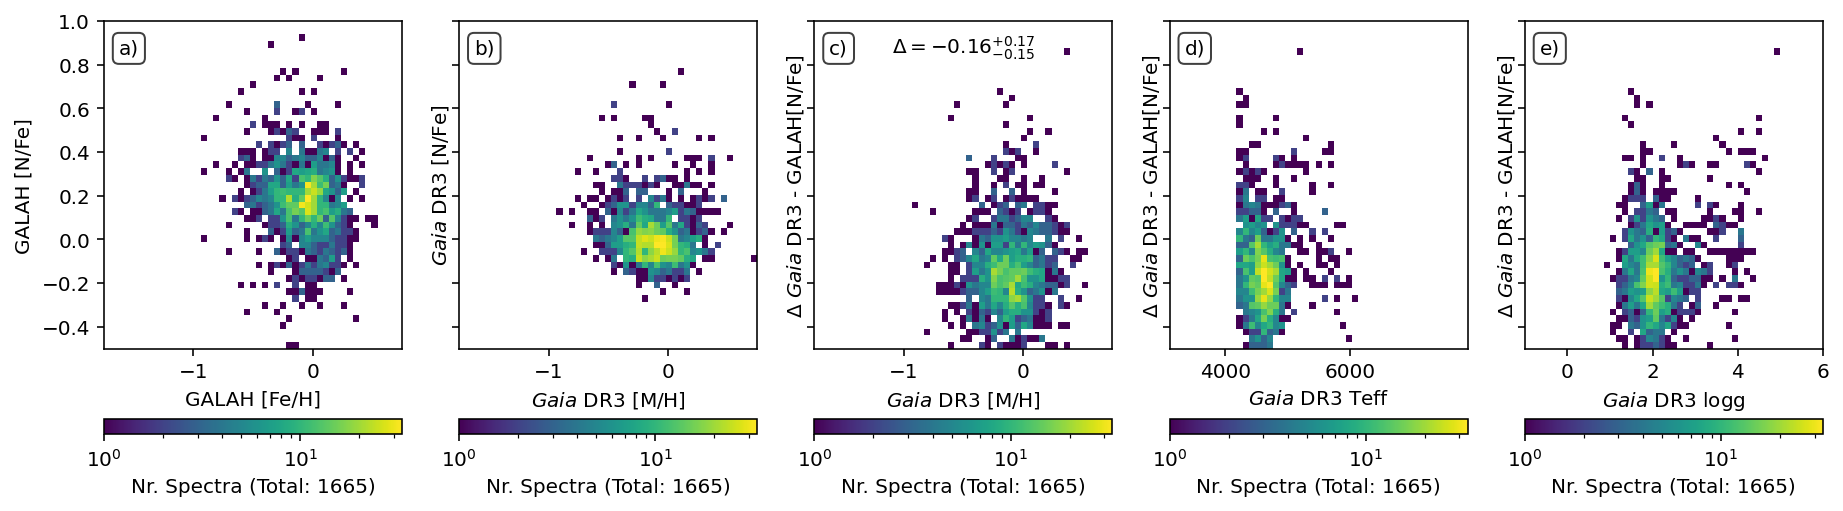

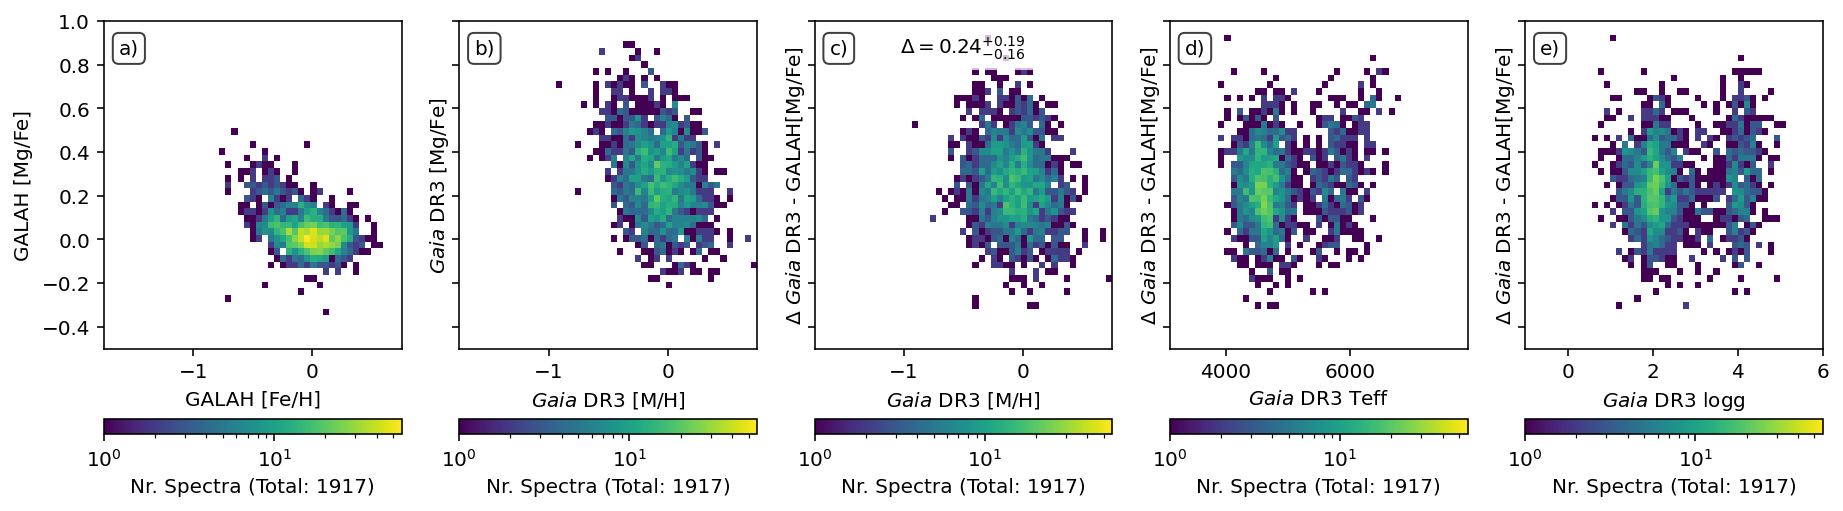

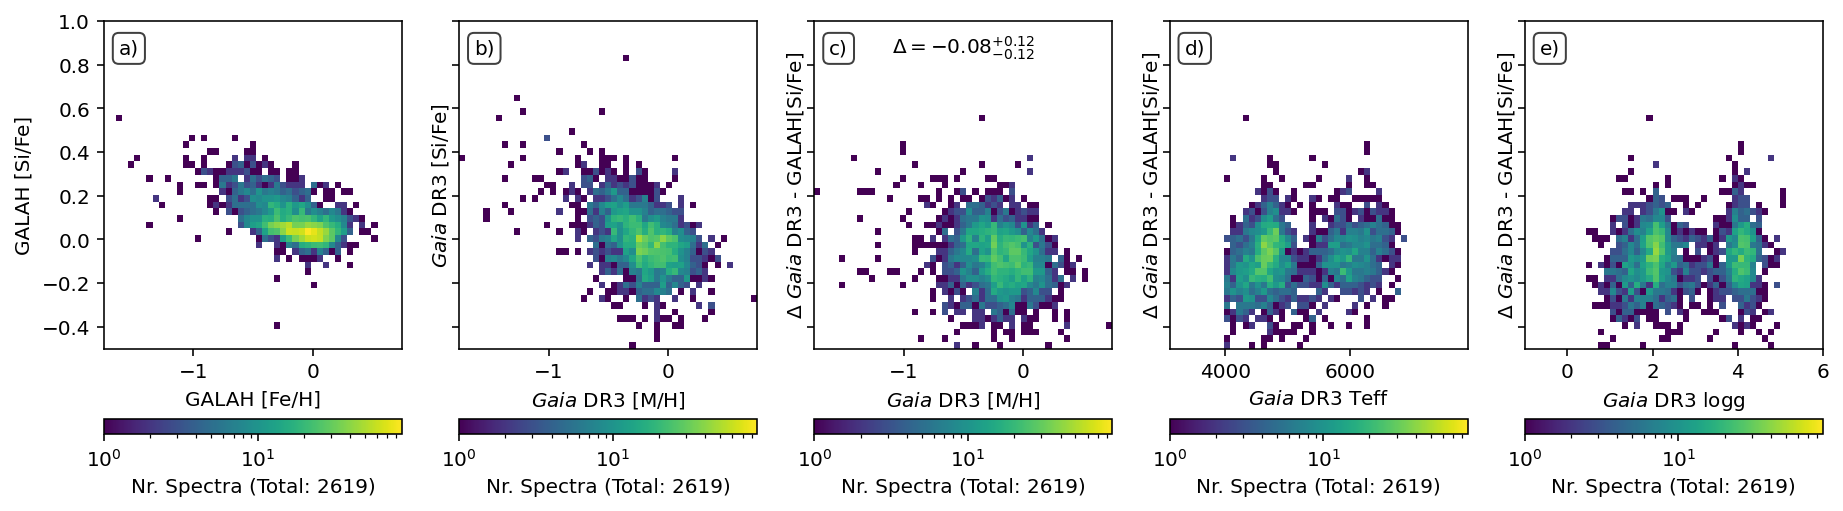

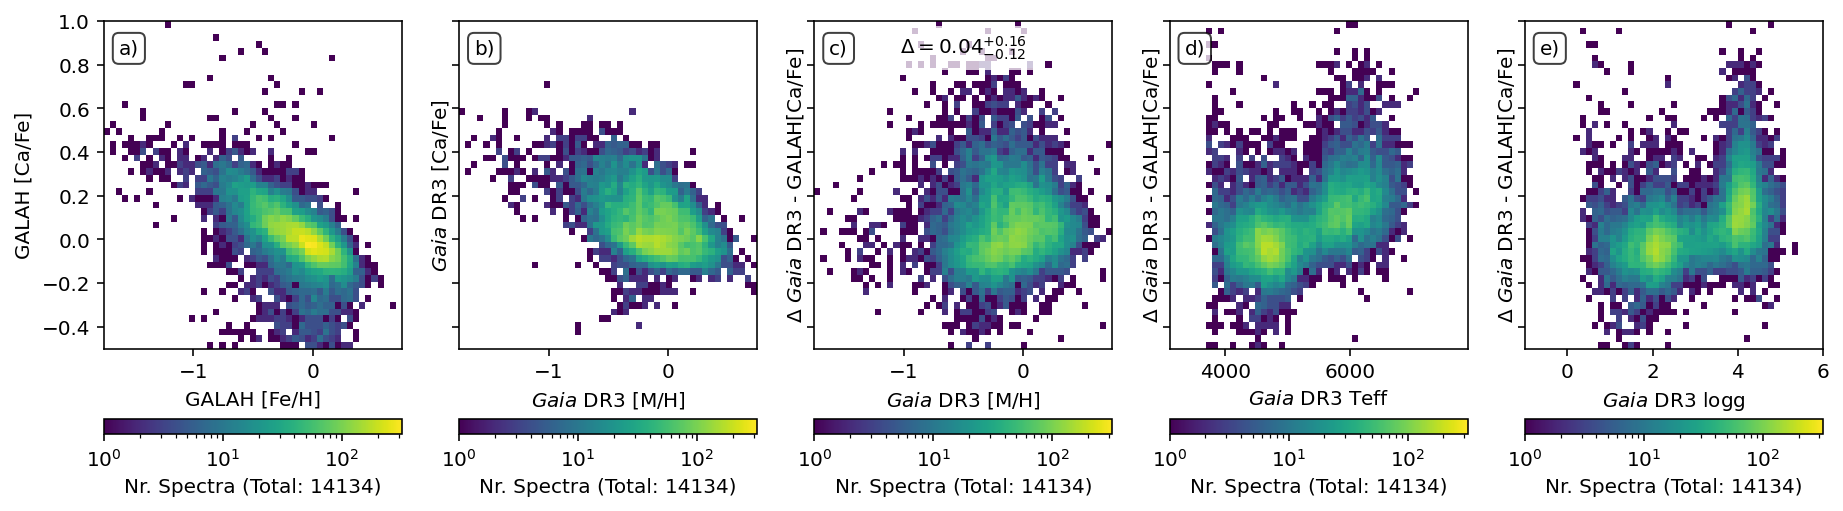

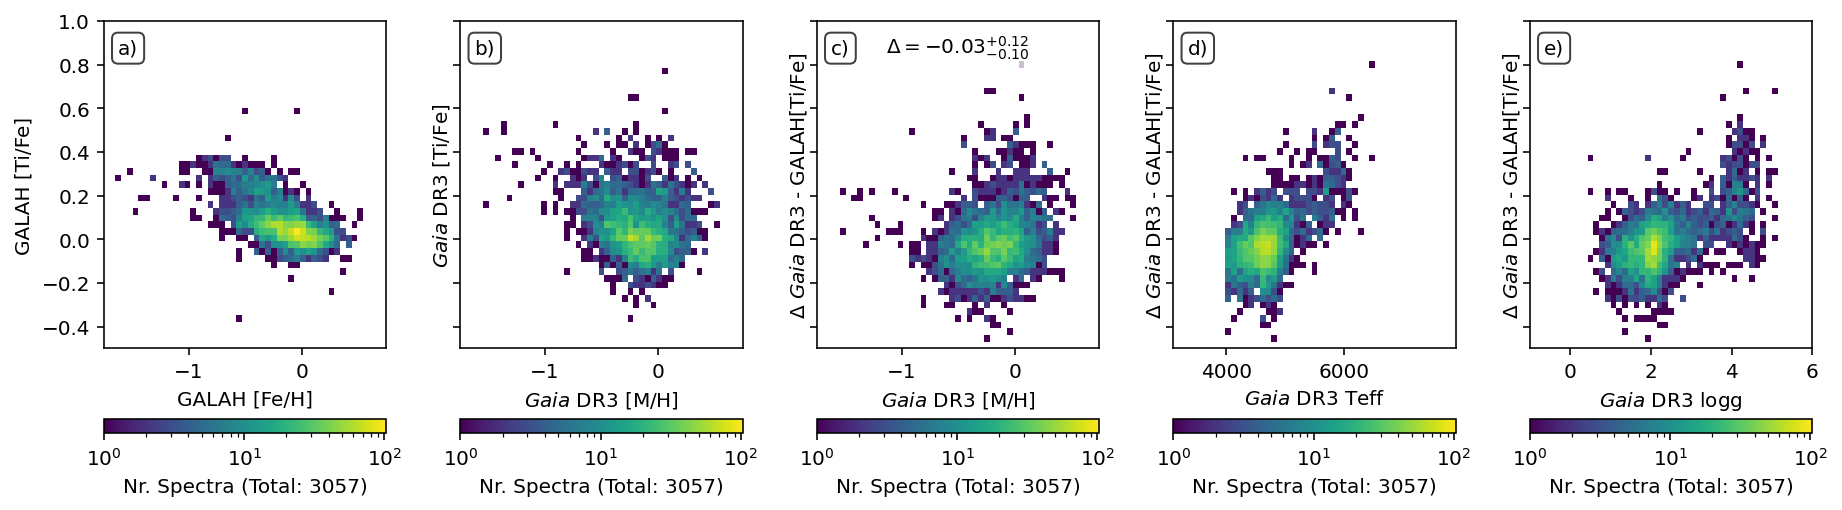

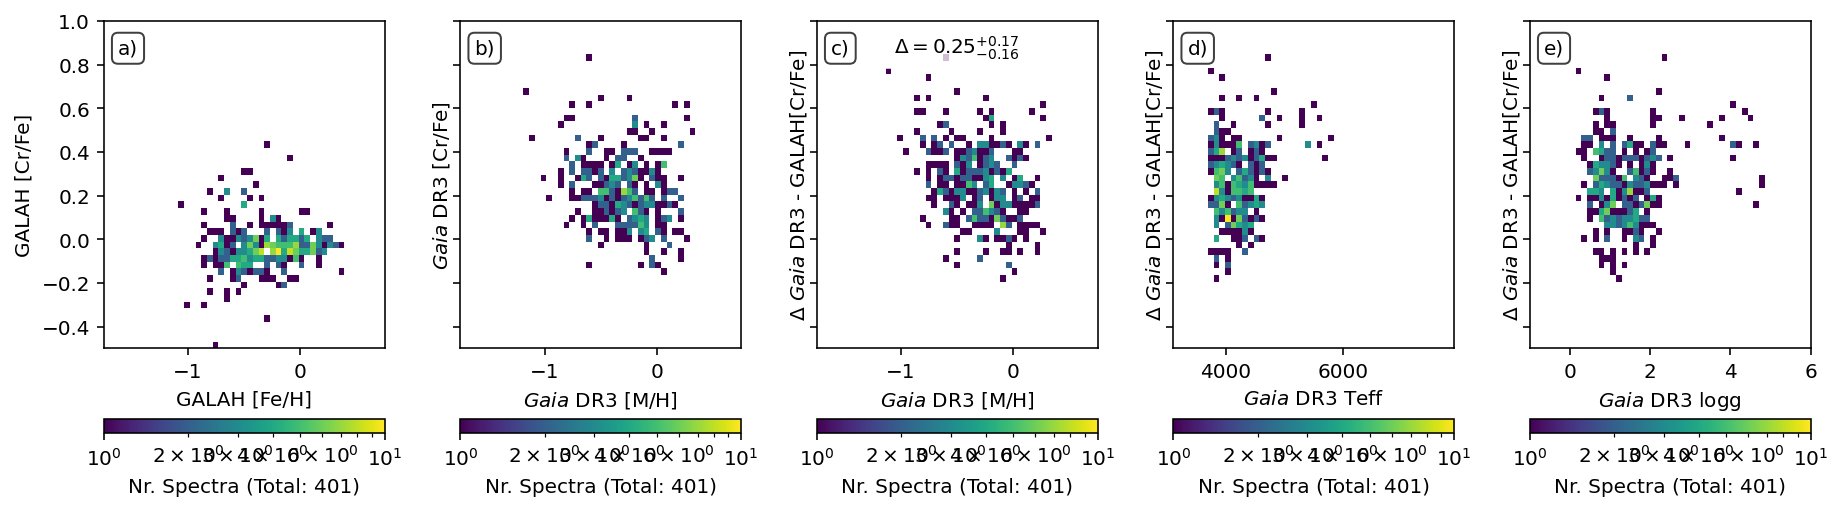

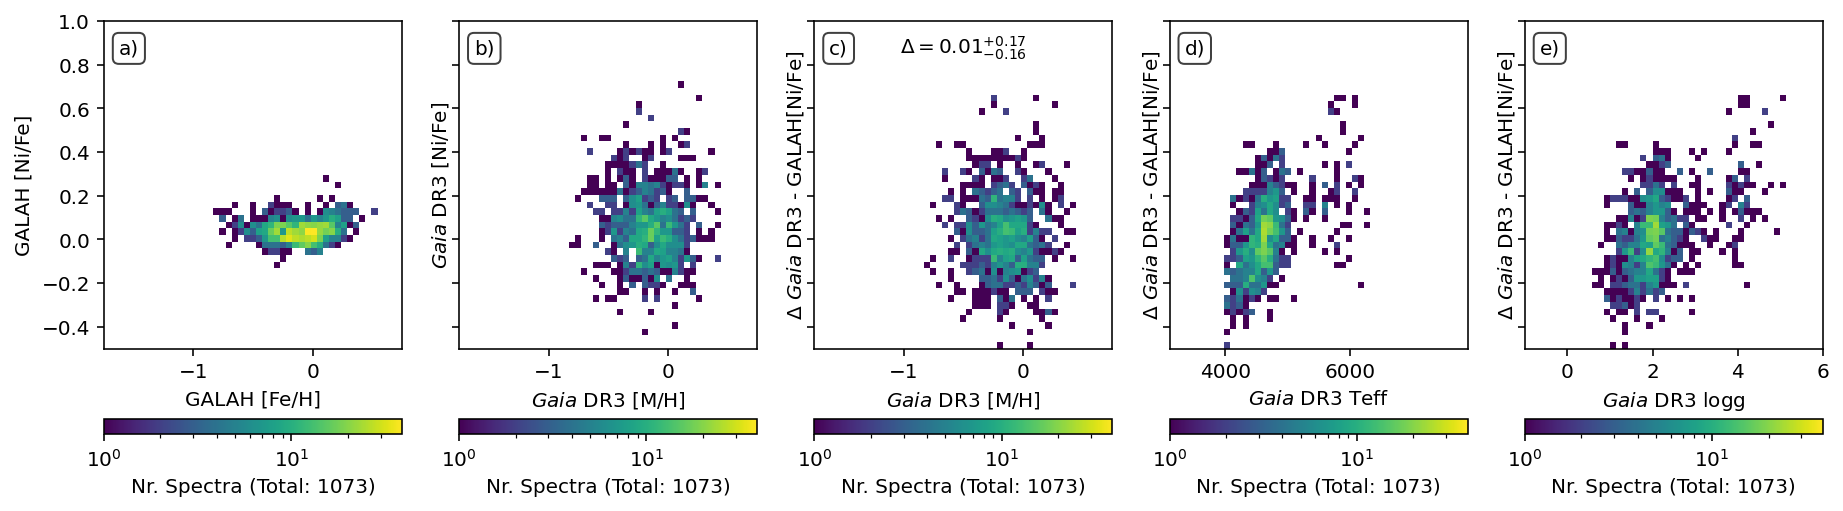

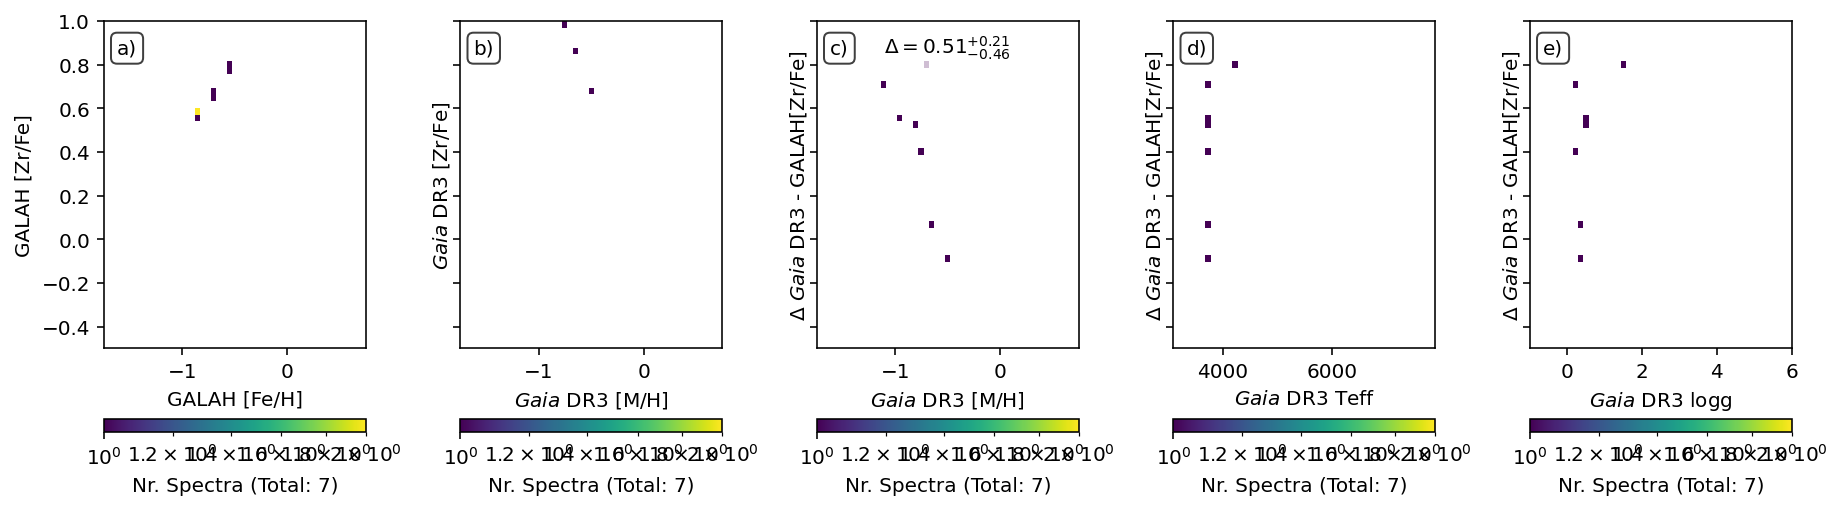

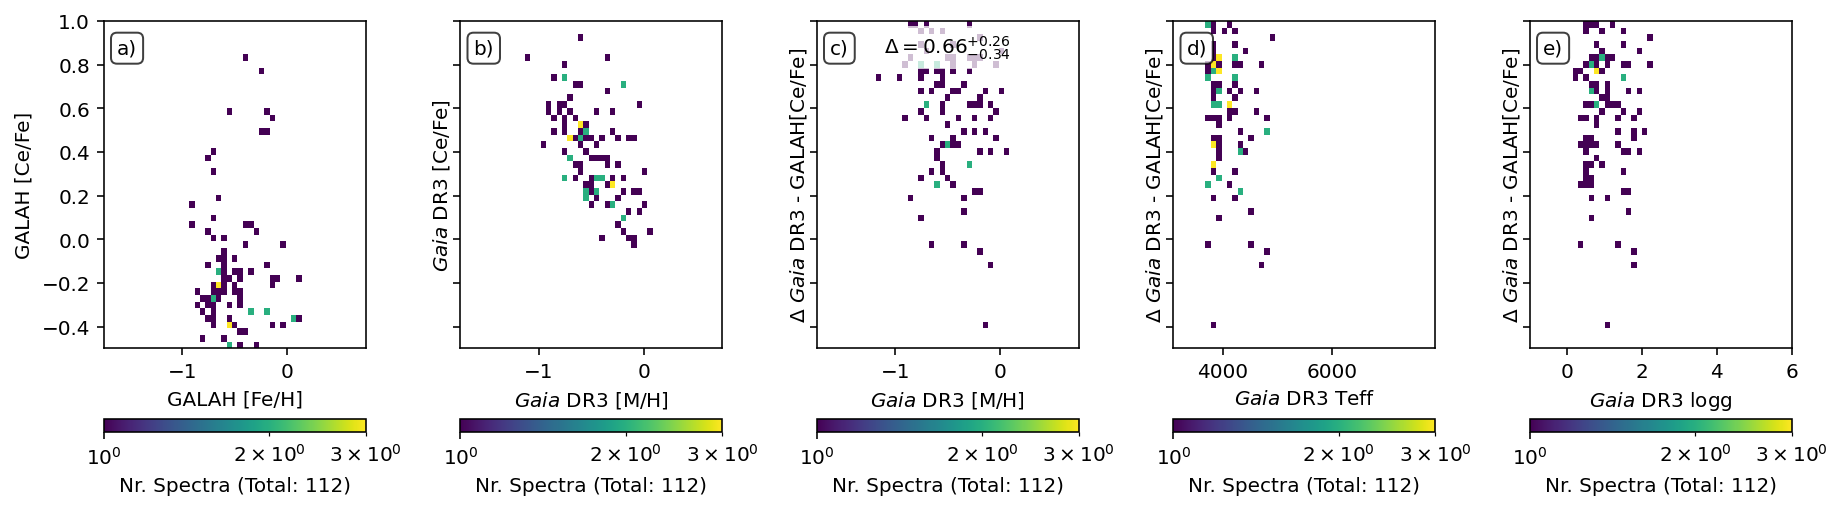

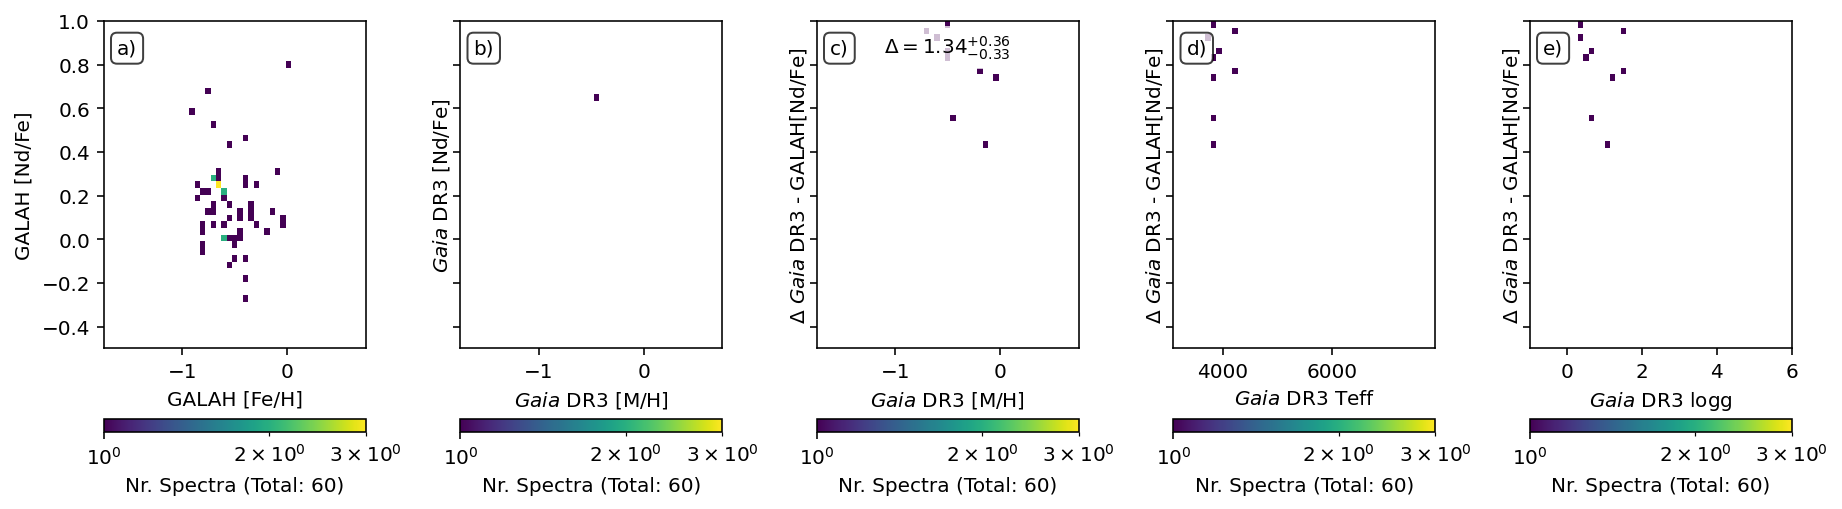

In [10]:
def calculate_difference_per_abundance(element):

    use = (
        (joined['flag_sp'] == 0) &
        (joined['flag_'+element.lower()+'_fe'] == 0) &
        np.isfinite(joined[element.lower()+'fe_gspspec'])
    )
    
    p16,p50,p84 = np.percentile(
        joined[element.lower()+'fe_gspspec'][use] - joined[element.lower()+'_fe'][use],
        q=[16,50,84]
    )
    
    f, gs = plt.subplots(1,5,figsize=(13,3.75),sharey=True)

    kwargs = dict(
        norm=LogNorm(),
        cmin=1,
    )
    
    # Panel a)
    ax = gs[0]
    ax.text(0.05,0.90,'a)',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'GALAH [Fe/H]')
    ax.set_ylabel(r'GALAH ['+element+'/Fe]')
    
    h = ax.hist2d(
        joined['fe_h'][use],
        joined[element.lower()+'_fe'][use],
        bins=(np.linspace(-1.75,0.75,50),np.linspace(-0.5,1,50)),
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['fe_h'][use]))+')')

    # Panel b)
    ax = gs[1]
    ax.text(0.05,0.90,'b)',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$Gaia$ DR3 [M/H]')
    ax.set_ylabel(r'$Gaia$ DR3 ['+element+'/Fe]')

    h = ax.hist2d(
        joined['mh_gspspec'][use],
        joined[element.lower()+'fe_gspspec'][use],
        bins=(np.linspace(-1.75,0.75,50),np.linspace(-0.5,1,50)),
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['fe_h'][use]))+')')
    
    # Panel c)
    ax = gs[2]
    ax.text(0.05,0.90,'c)',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$Gaia$ DR3 [M/H]')
    ax.set_ylabel(r'$\Delta$ $Gaia$ DR3 - GALAH['+element+'/Fe]')

    h = ax.hist2d(
        joined['mh_gspspec'][use],
        joined[element.lower()+'fe_gspspec'][use] - joined[element.lower()+'_fe'][use],
        bins=(np.linspace(-1.75,0.75,50),np.linspace(-0.5,1,50)),
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['fe_h'][use]))+')')
    
    gs[2].text(0.5,0.9,
            r'$\Delta = {'+"{:.2f}".format(p50)+'}_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$',
            transform=gs[2].transAxes,fontsize=10,ha='center',bbox=dict(lw=0, facecolor='w', alpha=0.75)
        )
    
    # Panel d)
    ax = gs[3]
    ax.text(0.05,0.90,'d)',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$Gaia$ DR3 Teff')
    ax.set_ylabel(r'$\Delta$ $Gaia$ DR3 - GALAH['+element+'/Fe]')

    h = ax.hist2d(
        joined['teff_gspspec'][use],
        joined[element.lower()+'fe_gspspec'][use] - joined[element.lower()+'_fe'][use],
        bins=(np.linspace(3100,7900,50),np.linspace(-0.5,1,50)),
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['fe_h'][use]))+')')
    
    # Panel e)
    ax = gs[4]
    ax.text(0.05,0.90,'e)',transform=ax.transAxes,fontsize=10,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$Gaia$ DR3 logg')
    ax.set_ylabel(r'$\Delta$ $Gaia$ DR3 - GALAH['+element+'/Fe]')
    
    h = ax.hist2d(
        joined['logg_gspspec'][use],
        joined[element.lower()+'fe_gspspec'][use] - joined[element.lower()+'_fe'][use],
        bins=(np.linspace(-1,6,50),np.linspace(-0.5,1,50)),
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['fe_h'][use]))+')')
        
    plt.tight_layout()
    
    plt.savefig('figures/galah_dr4_validation_gaiadr3_delta_'+element.lower()+'.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

for element in ['N','Mg','Si','Ca','Ti','Cr','Ni','Zr','Ce','Nd']:
    
    calculate_difference_per_abundance(element)